# **Product Demand Forecasting**

---



## Objective

The goal of this project is to forecast future demand for 51 products across 77 logistics centers using advanced machine learning techniques.

## Scope

This project leverages a Kaggle dataset that captures retail sales behavior. By analyzing key variables such as seasonality, pricing, and promotions, the models predict weekly product demand with a strong focus on accuracy and generalization. I apply regression techniques, cross-validation, and performance metrics (RMSE, MSE, MAE, R²) to evaluate and validate the models.

## Modeling Approach

A hybrid model combining Linear Regression and XGBoost Regressor is used. Linear Regression captures global trends and seasonal patterns effectively, while XGBoost models non-linear interactions and uncovers complex residual behaviors.

## Dataset

The kaggle dataset can be found at the following link [Food_Demand_Forecasting](https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/data)

The link has attached several datasets:

* meal_info (products)
* fufilment_center_info (Logistics center)
* train (sales history with target column)
* test (sales history without target column)


# Data Loading

In [66]:
# ! pip install --upgrade xgboost==3.0.2
import xgboost
print(xgboost.__version__)

3.0.2


In [67]:
%reset -f
# Standard Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import ipywidgets as widgets
# from IPython.display import display
# --- Modeling & Machine Learning ---
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
# Data Preprocessing ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# Model Selection & Evaluation ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import (mean_squared_error,mean_absolute_error,r2_score)
# Time Series Tools ---
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.deterministic import Fourier as stmfourier
# Warnings Filtering ---
import warnings
warnings.filterwarnings("ignore")
print("Librerías importadas y kernel reiniciado.")

Librerías importadas y kernel reiniciado.


In [68]:
# Load the Data from Kaggle
# Install and upgrade the kaggle version to access data in kaggle.
!pip install -q -U kagglehub
!pip show kagglehub  | grep -E 'Name|Version'

import kagglehub
path = kagglehub.dataset_download("kannanaikkal/food-demand-forecasting")
print("Path to dataset files:", path)

Name: kagglehub
Version: 0.3.12
                           Version 2.0, January 2004
   Licensed under the Apache License, Version 2.0 (the "License");
Path to dataset files: /kaggle/input/food-demand-forecasting


In [69]:
# Verify the downloaded files ---
os.listdir(path)

['meal_info.csv',
 'sample_submission.csv',
 'fulfilment_center_info.csv',
 'train.csv',
 'test.csv']

In [70]:
# Read the train dataset ---
dataset_path = os.path.join(path, 'train.csv')
d_train = pd.read_csv(dataset_path)
df_train = d_train.copy()
# Convert week number to date ---
start_date = pd.to_datetime('2025-01-01')
df_train['date'] = start_date + pd.to_timedelta((df_train['week'] - 1) * 7, unit='D')
# Verify the index type after loading ---
print("Index type after loading:", df_train.index.dtype)
df_train.head()

Index type after loading: int64


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,date
0,1379560,1,55,1885,136.83,152.29,0,0,177,2025-01-01
1,1466964,1,55,1993,136.83,135.83,0,0,270,2025-01-01
2,1346989,1,55,2539,134.86,135.86,0,0,189,2025-01-01
3,1338232,1,55,2139,339.50,437.53,0,0,54,2025-01-01
4,1448490,1,55,2631,243.50,242.50,0,0,40,2025-01-01


In [71]:
# Read the reference dataset meal_id ---
dataset_path = os.path.join(path, 'meal_info.csv')
d_meal = pd.read_csv(dataset_path)
df_meal = d_meal.copy()
df_meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [72]:
# # Read the reference dataset new test ---
# dataset_path = os.path.join(path, 'test.csv')
# d_new = pd.read_csv(dataset_path, index_col = "week")
# df_new_test =d_new.copy()
# df_new_test.head()

In [73]:
# Read the reference dataset center_id ---
dataset_path = os.path.join(path, 'fulfilment_center_info.csv')
d_center = pd.read_csv(dataset_path)
df_center =d_center.copy()
df_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


## Preliminary exploration

This section explores the dataset to verify its structure, integrity, and content.

In [74]:
# Validate the size of the datasets ---
print(f"datos of train:{df_train.shape}")
print(f"datos of meal:{df_meal.shape}")
print(f"datos of center:{df_center.shape}")
# print(f"datos of test: {df_new_test.shape}")

datos of train:(456548, 10)
datos of meal:(51, 3)
datos of center:(77, 5)


In [75]:
# Analyze whether the training and test datasets contain missing data ---
print(f"information of training data: {df_train.info()} \n \n ")
# print(f"information of training data: {df_new_test.info()} \n \n ")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     456548 non-null  int64         
 1   week                   456548 non-null  int64         
 2   center_id              456548 non-null  int64         
 3   meal_id                456548 non-null  int64         
 4   checkout_price         456548 non-null  float64       
 5   base_price             456548 non-null  float64       
 6   emailer_for_promotion  456548 non-null  int64         
 7   homepage_featured      456548 non-null  int64         
 8   num_orders             456548 non-null  int64         
 9   date                   456548 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 34.8 MB
information of training data: None 
 
 


In [76]:
# Analyze whether the reference meal and center_id contain missing data. ---
print(f"information of meal: {df_meal.info()} \n \n")
print(f"information of logistics center: {df_center.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
information of meal: None 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB
information of logistics center: None


* Detection of duplicated rows:

In [77]:
# Check for duplicated rows in the training, meal, and center datasets ---
duplicados_train = df_train.duplicated()
duplicados_meal = df_meal.duplicated()
duplicados_center = df_center.duplicated()
print(f"Duplicated rows in train: {duplicados_train.sum()}")
print(f"Duplicated rows in meal: {duplicados_meal.sum()}")
print(f"Duplicated rows in center: {duplicados_center.sum()}")

Duplicated rows in train: 0
Duplicated rows in meal: 0
Duplicated rows in center: 0


In [78]:
# Remove leading/trailing spaces in 'category' and 'cuisine' columns before merging. ---
df_meal['cuisine'] = df_meal['cuisine'].str.strip()
df_meal['category'] = df_meal['category'].str.strip()
# Display the number of rows for each column after cleaning ---
print(f"row_category: {df_meal['category'].size}, row_cuisine: {df_meal['cuisine'].size}")

row_category: 51, row_cuisine: 51


## Merged


In [79]:
# Merge meal and center information into the training dataset. ---
df_train = pd.merge(df_train, df_meal, on='meal_id', how='inner')
df_train = pd.merge(df_train, df_center, on='center_id', how='inner')

# Display summary information about the training dataset ---
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     456548 non-null  int64         
 1   week                   456548 non-null  int64         
 2   center_id              456548 non-null  int64         
 3   meal_id                456548 non-null  int64         
 4   checkout_price         456548 non-null  float64       
 5   base_price             456548 non-null  float64       
 6   emailer_for_promotion  456548 non-null  int64         
 7   homepage_featured      456548 non-null  int64         
 8   num_orders             456548 non-null  int64         
 9   date                   456548 non-null  datetime64[ns]
 10  category               456548 non-null  object        
 11  cuisine                456548 non-null  object        
 12  city_code              456548 non-null  int6

In [80]:
# Display summary statistics for the dataset ---
df_train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,date,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,2026-06-01 09:09:12.882938880,601.553399,56.614566,4.083590
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,2025-01-01 00:00:00,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,2025-09-24 00:00:00,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,2026-06-10 00:00:00,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,2027-02-10 00:00:00,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,2027-10-06 00:00:00,713.000000,93.000000,7.000000
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,NaN,66.195914,17.641306,1.091686


In [81]:
# Aggregate order statistics by center_id and meal_id ---
agg_features = df_train.groupby(['center_id', 'meal_id']).agg({
    'num_orders': ['mean', 'std', 'min', 'max', 'count']
})
# Includes mean, std, min, max, and count of num_orders. Aggregate price-related variables if needed ---
# agg_features[('checkout_price', 'mean')] = df_train.groupby(['center_id', 'meal_id'])['checkout_price'].mean()
# agg_features[('base_price', 'mean')] = df_train.groupby(['center_id', 'meal_id'])['base_price'].mean()
# agg_features.columns = ['_'.join(col) for col in agg_features.columns]  # aplanar nombres

agg_features

num_orders                             
                          mean         std  min   max count
center_id meal_id                                          
10        1062      949.944828  260.404514  161  1810   145
          1109     1528.862069  633.612632  311  3996   145
          1198      347.537931  142.068353  107   784   145
          1207      215.493056  176.502224   13  1122   144
          1216      146.433566   58.937130   13   366   143
...                        ...         ...  ...   ...   ...
186       2707      206.924138   77.783182   53   433   145
          2760       60.375887   42.132875   13   284   141
          2826      271.391608  148.348326   27  1176   143
          2867       37.717172   34.870033   13   217    99
          2956       32.400000   20.321730   13   122    45

[3597 rows x 5 columns]

## Feature engineering

In [82]:
# Now, Feature engineering and data transformation ---

# Create discount-related features ---
df_train["checkout_base_price"] = df_train["checkout_price"] / df_train["base_price"]
df_train["nivel_descount"] = df_train["checkout_base_price"] - 1
df_train["sensitity_promo"] = df_train["nivel_descount"] * df_train["emailer_for_promotion"]


# Convert columns to categorical types
df_train["meal_id"] = df_train["meal_id"].astype('category')
df_train["op_area"] = df_train["op_area"].astype('category')
df_train["city_code"] = df_train["city_code"].astype('category')
df_train["region_code"] = df_train["region_code"].astype('category')
df_train["center_id"] = df_train["center_id"].astype('category')
df_train["category"] = df_train["category"].astype('category')
df_train["cuisine"] = df_train["cuisine"].astype('category')
df_train["center_type"] = df_train["center_type"].astype('category')

# Create composite key for center-meal combination
df_train["center_meal"] = df_train["center_id"].astype(str) + "-" + df_train["meal_id"].astype(str)
df_train["center_meal"] = df_train["center_meal"].astype('category')


# Select relevant features and set MultiIndex (date, center_meal) ---
df_train = df_train[["date","id","center_meal","category","center_id","meal_id","num_orders","checkout_price","sensitity_promo","emailer_for_promotion","homepage_featured"]]
df_train = df_train.set_index(["date"])

# Time features
# Extract day, month, and year from the datetime index
df_train["day"] = df_train.index.day
df_train["month"] = df_train.index.month
df_train["year"] = df_train.index.year
# Create a season feature based on the month
df_train["season"] = df_train["month"] % 12 // 3 + 1
df_train["season"] = df_train["season"].astype("category")
df_train["year"] = df_train["year"].astype("category")
df_train["month"] = df_train["month"].astype("category")

df_train = df_train.set_index(["center_meal"], append=True).sort_index()
df_train

id      category center_id meal_id  num_orders  \
date       center_meal                                                        
2025-01-01 10-1062      1436842     Beverages        10    1062         865   
           10-1109      1142165     Rice Bowl        10    1109        2672   
           10-1198      1421626        Extras        10    1198         269   
           10-1207      1260561     Beverages        10    1207         769   
           10-1216      1411421         Pasta        10    1216          54   
...                         ...           ...       ...     ...         ...   
2027-10-06 99-2704      1353022  Other Snacks        99    2704          82   
           99-2707      1287238     Beverages        99    2707         701   
           99-2760      1498225  Other Snacks        99    2760         108   
           99-2826      1133985      Sandwich        99    2826         567   
           99-2867      1190738       Seafood        99    2867          42   

                        checkout_price  sensitity_promo  \
date       center_meal                                    
2025-01-01 10-1062              181.39         0.000000   
           10-1109              231.86        -0.161386   
           10-1198              129.04        -0.000000   
           10-1207              322.07        -0.000000   
           10-1216              455.93         0.000000   
...                                ...              ...   
2027-10-06 99-2704              320.13         0.000000   
           99-2707              241.59         0.000000   
           99-2760              163.99        -0.000000   
           99-2826              379.33         0.000000   
           99-2867              726.53        -0.000000   

                        emailer_for_promotion  homepage_featured  day month  \
date       center_meal                                                        
2025-01-01 10-1062                          0                  0    1     1   
           10-1109                          1                  0    1     1   
           10-1198                          0                  0    1     1   
           10-1207                          0                  0    1     1   
           10-1216                          0                  0    1     1   
...                                       ...                ...  ...   ...   
2027-10-06 99-2704                          0                  0    6    10   
           99-2707                          0                  0    6    10   
           99-2760                          0                  0    6    10   
           99-2826                          0                  0    6    10   
           99-2867                          0                  0    6    10   

                        year season  
date       center_meal               
2025-01-01 10-1062      2025      1  
           10-1109      2025      1  
           10-1198      2025      1  
           10-1207      2025      1  
           10-1216      2025      1  
...                      ...    ...  
2027-10-06 99-2704      2027      4  
           99-2707      2027      4  
           99-2760      2027      4  
           99-2826      2027      4  
           99-2867      2027      4  

[456548 rows x 13 columns]

In [83]:
# Ensure the index is sorted by time ---
df_train = df_train.sort_index()

## Create lag features ---
df_train["lag_1"]= df_train.groupby(["center_id","meal_id"], observed=True)["num_orders"].shift(1)#.astype('float32')#.fillna(0)
df_train["lag_2"]= df_train.groupby(["center_id","meal_id"], observed=True)["num_orders"].shift(2)#.astype('float32')
df_train["lag_3"]= df_train.groupby(["center_id","meal_id"], observed=True)["num_orders"].shift(3)#.astype('float32')


## Create rolling median features for num_orders using different time windows (4, 13, 52 weeks), ---
# grouped by center_meal. Shifted by 1 to avoid data leakage ---

for window in [4, 13, 52]:  # quincenal y bimensual ,[2, 8, 52]4, 8, 13, 26,
    df_train[f'rolling_mean_{window}'] = (
        df_train
        .groupby(['center_id', 'meal_id'],observed=True)['num_orders']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).median())#.astype('float32')
    )

    # df_train[f'rolling_std_{window}'] = (
    #     df_train
    #     .groupby(['center_id', 'meal_id'],observed=True)['num_orders']
    #     .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
    # )


## Create rolling minimum and maximum features for num_orders using time windows ---

for window in [4,13]:
    df_train[f'rolling_min_{window}'] = (
        df_train
        .groupby(['center_id', 'meal_id'],observed=True)['num_orders']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).min())#.astype('float32')
    )

    df_train[f'rolling_max_{window}'] = (
        df_train
        .groupby(['center_id', 'meal_id'],observed=True)['num_orders']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).max())#.astype('float32')
    )

In [84]:
# Compute correlation matrix for all numerical features ---
df_train.select_dtypes(include='number').corr()

,id,num_orders,checkout_price,sensitity_promo,emailer_for_promotion,homepage_featured,day,lag_1,lag_2,lag_3,rolling_mean_4,rolling_mean_13,rolling_mean_52,rolling_min_4,rolling_max_4,rolling_min_13,rolling_max_13
id,1.000000,0.000702,0.001941,-0.002256,0.002001,0.003111,-0.000583,-0.000746,-0.001932,-0.003064,-0.001742,-0.001173,-0.000950,-0.000489,-0.002102,-0.000633,-0.000463
num_orders,0.000702,1.000000,-0.282108,-0.296648,0.277147,0.294490,0.017248,0.698363,0.589095,0.525110,0.661507,0.691059,0.686910,0.655216,0.607939,0.644158,0.558476
checkout_price,0.001941,-0.282108,1.000000,0.008200,0.004818,-0.057184,0.000116,-0.250665,-0.223676,-0.213679,-0.273256,-0.333522,-0.346292,-0.315855,-0.189623,-0.319789,-0.144958
sensitity_promo,-0.002256,-0.296648,0.008200,1.000000,-0.886806,-0.370547,-0.013432,-0.095550,-0.012479,0.019354,0.000465,0.036872,0.036330,0.036226,-0.056137,0.040196,-0.043884
emailer_for_promotion,0.002001,0.277147,0.004818,-0.886806,1.000000,0.390534,0.005947,0.089516,0.005803,-0.014197,0.003315,-0.021429,-0.022380,-0.021956,0.049353,-0.025470,0.036995
homepage_featured,0.003111,0.294490,-0.057184,-0.370547,0.390534,1.000000,0.004422,0.188905,0.107577,0.074487,0.115899,0.094702,0.088733,0.102613,0.127352,0.095074,0.078565
day,-0.000583,0.017248,0.000116,-0.013432,0.005947,0.004422,1.000000,-0.013151,-0.014893,0.006882,-0.000456,-0.001687,-0.001641,0.000104,-0.004741,-0.001641,-0.003722
lag_1,-0.000746,0.698363,-0.250665,-0.095550,0.089516,0.188905,-0.013151,1.000000,0.697700,0.588111,0.772836,0.711676,0.696948,0.723729,0.799851,0.662480,0.652245
lag_2,-0.001932,0.589095,-0.223676,-0.012479,0.005803,0.107577,-0.014893,0.697700,1.000000,0.696905,0.865517,0.721533,0.701459,0.746590,0.803220,0.666521,0.651694
lag_3,-0.003064,0.525110,-0.213679,0.019354,-0.014197,0.074487,0.006882,0.588111,0.696905,1.000000,0.875082,0.722861,0.701525,0.744470,0.791884,0.665783,0.650891


### y : Target

In [85]:
# Define the target variable (number of orders)
y = df_train.loc[:, 'num_orders']
y

date        center_meal
2025-01-01  10-1062         865
            10-1109        2672
            10-1198         269
            10-1207         769
            10-1216          54
                           ... 
2027-10-06  99-2704          82
            99-2707         701
            99-2760         108
            99-2826         567
            99-2867          42
Name: num_orders, Length: 456548, dtype: int64

### X_1: deterministic process features (linear model)

In [86]:
# X_1: Features for the first Linear Regression model

# Define Fourier terms for capturing annual, monthly, and quarterly seasonality
# fourier_y = CalendarFourier(freq= 'YE', order= 6)

# Define a deterministic process for trend modeling
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    #seasonal= True,
    #additional_terms=[fourier_y],
    drop= True  # Drop terms to avoid multicollinearity
    )

# Generate the in-sample predictors (features)
X_1 = dp.in_sample()

# Restore the original MultiIndex
X_1.index = y.index
X_1

const     trend
date       center_meal                 
2025-01-01 10-1062        1.0       1.0
           10-1109        1.0       2.0
           10-1198        1.0       3.0
           10-1207        1.0       4.0
           10-1216        1.0       5.0
...                       ...       ...
2027-10-06 99-2704        1.0  456544.0
           99-2707        1.0  456545.0
           99-2760        1.0  456546.0
           99-2826        1.0  456547.0
           99-2867        1.0  456548.0

[456548 rows x 2 columns]

### X_2_label: Features for XGBoost model

In [87]:
X_2_label = df_train.drop(["num_orders","id"], axis=1)
X_2_label =  X_2_label.reset_index(["center_meal"])
X_2_label

,center_meal,category,center_id,meal_id,checkout_price,sensitity_promo,emailer_for_promotion,homepage_featured,day,month,...,lag_1,lag_2,lag_3,rolling_mean_4,rolling_mean_13,rolling_mean_52,rolling_min_4,rolling_max_4,rolling_min_13,rolling_max_13
date,,,,,,,,,,,,,,,,,,,,,
2025-01-01,10-1062,Beverages,10,1062,181.39,0.000000,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,10-1109,Rice Bowl,10,1109,231.86,-0.161386,1,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,10-1198,Extras,10,1198,129.04,-0.000000,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,10-1207,Beverages,10,1207,322.07,-0.000000,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,10-1216,Pasta,10,1216,455.93,0.000000,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-10-06,99-2704,Other Snacks,99,2704,320.13,0.000000,0,0,6,10,...,175.0,68.0,121.0,148.0,150.0,135.0,68.0,177.0,68.0,230.0
2027-10-06,99-2707,Beverages,99,2707,241.59,0.000000,0,0,6,10,...,1120.0,1162.0,717.0,964.5,890.0,1141.5,717.0,1162.0,377.0,1162.0
2027-10-06,99-2760,Other Snacks,99,2760,163.99,-0.000000,0,0,6,10,...,163.0,95.0,41.0,102.0,95.0,95.0,41.0,163.0,41.0,163.0


### Visualize DataFrames

In [88]:
# # import ipywidgets as widgets
# # from IPython.display import display

# # Function to load all datasets ---
# def load_multistep_data():
#     df1 = df_train
#     df2 = X_1
#     df4 = X_2_label
#     df5 = y
#     df6 = agg_features
#     return {'df_train': df1, 'X_1': df2,'X_2_label': df4,'y': df5 , 'agg_features': df6 }

# # Load datasets ---
# datasets = load_multistep_data()

# # Create one output widget per dataset ---
# outputs = [widgets.Output() for _ in datasets]
# data_tabs = widgets.Tab(children=outputs)

# # Set tab titles to dataset names and display each  ---
# for i, (name, df) in enumerate(datasets.items()):
#     data_tabs.set_title(i, name)
#     with outputs[i]:
#         display(df)

# # Display tabs ---
# display(data_tabs)


In [89]:
# Check data types before passing X_2_label into the XGBoost model
X_2_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456548 entries, 2025-01-01 to 2027-10-06
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   center_meal            456548 non-null  category
 1   category               456548 non-null  category
 2   center_id              456548 non-null  category
 3   meal_id                456548 non-null  category
 4   checkout_price         456548 non-null  float64 
 5   sensitity_promo        456548 non-null  float64 
 6   emailer_for_promotion  456548 non-null  int64   
 7   homepage_featured      456548 non-null  int64   
 8   day                    456548 non-null  int32   
 9   month                  456548 non-null  category
 10  year                   456548 non-null  category
 11  season                 456548 non-null  category
 12  lag_1                  452951 non-null  float64 
 13  lag_2                  449357 non-null  float64 
 14  lag_

## Build the Boosting Model

In [90]:
## Remove intercept
X_1 = X_1.drop(columns=['const'], errors='ignore')

# Scale X_1 before applying linear regression
scaler = StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1), columns=X_1.columns, index=X_1.index)

# Ensure chronological order for all datasets
X_1 = X_1.sort_index()
X_2_label = X_2_label.sort_index()
y = y.sort_index().fillna(0)

# Generate cross-validation folds using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Initialize lists to store evaluation metrics for each fold
rmse_train_list = []
rmse_valid_list = []
mae_train_list = []
mae_valid_list = []
r2_train_list = []
r2_valid_list = []

# Define the hyperparameter search space for XGBoost
param_dist = {
    "n_estimators": randint(100, 500),
    "learning_rate": uniform(0.01, 1),
    "max_depth": randint(3, 10),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_1)):
  # ----------------------------------------------------------------------
  # Get dates for the current fold
  train_dates = X_1.index[train_idx]
  val_dates = X_1.index[val_idx]
  print(f"⏳ Fold {fold + 1}")
  # Display date ranges for each fold
  print(f"  Train dates: {train_dates[0][0].date()} → {train_dates[-1][0].date()}")
  print(f"  Valid dates: {val_dates[0][0].date()} → {val_dates[-1][0].date()}")
  # ----------------------------------------------------------------------

  # Split for model 1
  X1_train, X1_valid = X_1.iloc[train_idx], X_1.iloc[val_idx]
  X2_train, X2_valid = X_2_label.iloc[train_idx], X_2_label.iloc[val_idx]

  # Target
  y_train, y_valid = y.iloc[train_idx], y.iloc[val_idx]



  # ------------------------------------------------------------
  # model_1 : Linear Regression
  # ------------------------------------------------------------
  model_1= LinearRegression()
  model_1.fit(X1_train, y_train)

  # Predict on training set X1_train
  y_pred_1 = pd.DataFrame(model_1.predict(X1_train), index = X1_train.index,columns=["num_orders"])
  # Compute residuals for training set
  # Convert both to Series
  y_train = y_train.squeeze()
  y_pred_1 = y_pred_1.squeeze()
  # Ensure both Series have the same index names
  y_pred_1.index.names = y_train.index.names
  # Calculate residuals: actual - predicted
  y_resid = y_train - y_pred_1

  # Predict on validation set X1_valid
  y_pred_3 = pd.DataFrame(model_1.predict(X1_valid), index = X1_valid.index,columns=["num_orders"])
  # Convert both to Series
  y_valid = y_valid.squeeze()
  y_pred_3 = y_pred_3.squeeze()
  # Compute residuals for validation set
  y_resid_valid= y_valid - y_pred_3

  # ------------------------------------------------------------

  # ------------------------------------------------------------
  # Model 2: XGBoost on residuals
  # ------------------------------------------------------------
  model_2 = XGBRegressor(enable_categorical=True,
                         max_depth = 6, #6, #**6,# 6 # + profundidad más capacidad de aprendizaje pero es posible caer en overfitting
                         learning_rate= 0.03, # 0.13367720186661747, # menos learning = aprendizaje mas lento. un learning más alto genera aprendizaje muy rapido y sobreajuste
                         n_estimators=  600, #**600, #400,#300 , #800,#154, # N de árboles Compensa con n_estimators: menor learning_rate → mayor n_estimators.
                         subsample= 0.4, #**0.3, #0.7, # porcentaje de datos usados por árbol. Controla overfitting.Valores típicos: 0.5 a 1.0. Menor valor = más regularización.
                         reg_alpha= 1.0 , #1.0,#Técnica para reducir overfitting: Elimina variables innecesarias al hacer que sus pesos sean cero, #Útil cuando tienes muchas variables, algunas irrelevantes #Incrementar reg_alpha puede simplificar el modelo y prevenir overfitting.
                         reg_lambda= 4 ,#**4,#4,#5 ,#1.0, # Técnica para reducir overfitting: Controla el tamaño de todos los pesos, pero sin eliminarlos. Útil cuando hay multicolinealidad o valores extremos en los datos.Ayuda a estabilizar el modelo.Penaliza los coeficientes grandes.
                         colsample_bytree= 0.4 ,#0.7,# columnas seleccionadas aleatoriamente para cada árbol.Similar a subsample, pero para columnas. Valores: 0.3 a 1.0
                         min_child_weight= 4, #4
                         random_state = 42 )
  # Train the second-stage model on the residuals from the first-stage model
  model_2.fit(X2_train, y_resid)

  # ---------------------------------------------------
  # search = RandomizedSearchCV(
  #     estimator=base_model_2,
  #     param_distributions=param_dist,
  #     n_iter=5,
  #     scoring='neg_root_mean_squared_error',
  #     cv=TimeSeriesSplit(n_splits=4),
  #     verbose=0,
  #     n_jobs=-1,
  #     random_state=42
  #     )
  # # Train the second-stage model on the residuals from the first-stage model
  # search.fit(X2_train, y_resid)

  # # Use the best model found by randomized search
  # model_2 = search.best_estimator_
  #-------------------------------------------------------

  # Predict on train set X_2_train
  y_pred_2 = pd.DataFrame(model_2.predict(X2_train), index = X2_train.index,columns=["num_orders"])
  y_pred_2 = y_pred_2.squeeze()
  # Reformat and align predictions
  y_pred_2.index = y_resid.index


  # Predict on validation set X2_valid
  y_pred_4 = pd.DataFrame(model_2.predict(X2_valid), index = X2_valid.index,columns=["num_orders"])
  # Reformat and align predictions
  y_pred_4 = y_pred_4.squeeze()
  y_pred_4.index = y_resid_valid.index

  # ------------------------------------------------------------
  # Combine model 1 and model 2 predictions
  # ------------------------------------------------------------
  y_pred = y_pred_1 + y_pred_2
  y_pred_valid = y_pred_3 + y_pred_4
  # -----------------------------------------------------------
  y_pred = y_pred #.clip(0)
  y_pred_valid = y_pred_valid #.clip(0)

  # ------------------------------------------------------------
  # Generate metrics : RMSE - R2
  # ------------------------------------------------------------

  # Calculate RMSE per folds
  rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
  rmse_train_list.append(rmse_train)

  rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
  rmse_valid_list.append(rmse_valid)

  # Calulate R² per folds
  r2_train= r2_score(y_train, y_pred)
  r2_train_list.append(r2_train)
  r2_valid = r2_score(y_valid, y_pred_valid)
  r2_valid_list.append(r2_valid)

  # Calculate MAE
  mae_train = mean_absolute_error(y_train, y_pred)
  mae_valid = mean_absolute_error(y_valid, y_pred_valid)
  mae_train_list.append(mae_train)
  mae_valid_list.append(mae_valid)

  print(f"✅ Fold {fold + 1} - MAE train: {mae_train:.2f} | MAE valid: {mae_valid:.2f}")
  print(f"✅ Fold {fold + 1} - RMSE train: {rmse_train:.2f} | RMSE valid: {rmse_valid:.2f}")
  print(f"✅ Fold {fold + 1} - R2 train: {r2_train:.2f} | R2 valid: {r2_valid:.2f}")
  print("\n")
print("Global Metrics")
print(" Mean RMSE (train):", np.mean(rmse_train_list))
print(" Mean RMSE (valid):", np.mean(rmse_valid_list))
print(" Mean MAE (train):", np.mean(mae_train_list))
print(" Mean MAE (valid):", np.mean(mae_valid_list))
print(" Mean R2 (train):", np.mean(r2_train_list))
print(" Mean R2 (valid):", np.mean(r2_valid_list))

⏳ Fold 1
  Train dates: 2025-01-01 → 2025-07-02
  Valid dates: 2025-07-02 → 2025-12-24
✅ Fold 1 - MAE train: 58.08 | MAE valid: 91.13
✅ Fold 1 - RMSE train: 96.76 | RMSE valid: 201.85
✅ Fold 1 - R2 train: 0.95 | R2 valid: 0.75


⏳ Fold 2
  Train dates: 2025-01-01 → 2025-12-24
  Valid dates: 2025-12-24 → 2026-06-10
✅ Fold 2 - MAE train: 62.22 | MAE valid: 84.33
✅ Fold 2 - RMSE train: 107.64 | RMSE valid: 188.38
✅ Fold 2 - R2 train: 0.94 | R2 valid: 0.78


⏳ Fold 3
  Train dates: 2025-01-01 → 2026-06-10
  Valid dates: 2026-06-10 → 2026-11-18
✅ Fold 3 - MAE train: 64.75 | MAE valid: 74.08
✅ Fold 3 - RMSE train: 115.10 | RMSE valid: 153.83
✅ Fold 3 - R2 train: 0.92 | R2 valid: 0.83


⏳ Fold 4
  Train dates: 2025-01-01 → 2026-11-18
  Valid dates: 2026-11-18 → 2027-04-28
✅ Fold 4 - MAE train: 64.42 | MAE valid: 76.60
✅ Fold 4 - RMSE train: 116.11 | RMSE valid: 148.04
✅ Fold 4 - R2 train: 0.92 | R2 valid: 0.85


⏳ Fold 5
  Train dates: 2025-01-01 → 2027-04-28
  Valid dates: 2027-04-28 → 2027-

In [91]:
# search.best_params_

## Importance features_Xgboost

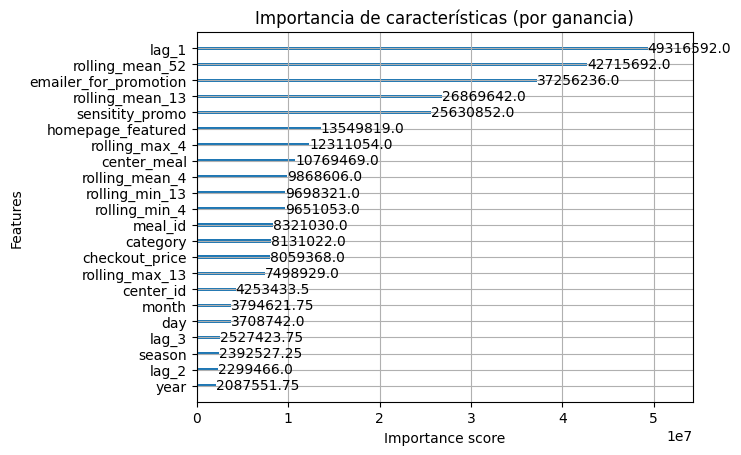

In [92]:
# Visualize
plot_importance(model_2, importance_type='gain', max_num_features=50)
#importance_type='gain': indica cuánto mejora el modelo con cada variable (métrica más útil).
plt.title("Importancia de características (por ganancia)")
plt.show()

In [93]:
# DataFrame
importances = model_2.get_booster().get_score(importance_type='gain')
import pandas as pd

importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(40))

                  Feature   Importance
12                  lag_1  49316592.00
17        rolling_mean_52  42715692.00
6   emailer_for_promotion  37256236.00
16        rolling_mean_13  26869642.00
5         sensitity_promo  25630852.00
7       homepage_featured  13549819.00
19          rolling_max_4  12311054.00
0             center_meal  10769469.00
15         rolling_mean_4   9868606.00
20         rolling_min_13   9698321.00
18          rolling_min_4   9651053.00
3                 meal_id   8321030.00
1                category   8131022.00
4          checkout_price   8059368.00
21         rolling_max_13   7498929.00
2               center_id   4253433.50
9                   month   3794621.75
8                     day   3708742.00
14                  lag_3   2527423.75
11                 season   2392527.25
13                  lag_2   2299466.00
10                   year   2087551.75


In [94]:
df_train.describe()

,id,num_orders,checkout_price,sensitity_promo,emailer_for_promotion,homepage_featured,day,lag_1,lag_2,lag_3,rolling_mean_4,rolling_mean_13,rolling_mean_52,rolling_min_4,rolling_max_4,rolling_min_13,rolling_max_13
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,452951.000000,449357.000000,445763.000000,452951.000000,452951.000000,452951.000000,452951.000000,452951.000000,452951.000000,452951.000000
mean,1.250096e+06,261.872760,332.238933,-0.019459,0.081152,0.10920,15.621172,262.432800,262.725481,263.127981,247.254259,225.950636,222.481123,162.226362,393.773845,117.485695,579.389556
std,1.443548e+05,395.922798,152.939723,0.073837,0.273069,0.31189,8.844003,396.837697,397.601438,398.425794,322.417381,263.271496,254.766580,227.124612,571.465804,175.955815,823.251625
min,1.000000e+06,13.000000,2.970000,-0.780873,0.000000,0.00000,1.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
25%,1.124999e+06,54.000000,228.950000,0.000000,0.000000,0.00000,8.000000,54.000000,54.000000,54.000000,55.000000,54.000000,54.500000,27.000000,96.000000,14.000000,148.000000
50%,1.250184e+06,136.000000,296.820000,0.000000,0.000000,0.00000,16.000000,136.000000,136.000000,136.000000,142.000000,135.000000,135.000000,80.000000,217.000000,53.000000,323.000000
75%,1.375140e+06,324.000000,445.230000,0.000000,0.000000,0.00000,23.000000,324.000000,324.000000,324.000000,317.500000,297.000000,296.000000,204.000000,472.000000,149.000000,674.000000
max,1.499999e+06,24299.000000,866.270000,0.394374,1.000000,1.00000,31.000000,24299.000000,24299.000000,24299.000000,14782.500000,5318.000000,3511.000000,7722.000000,24299.000000,3511.000000,24299.000000


## Visualizing Predicted vs Actual Demand

In [95]:
y_unstack = y.unstack()
y_pred_unstack = y_pred.unstack()
y_pred_valid_unstack = y_pred_valid.unstack()

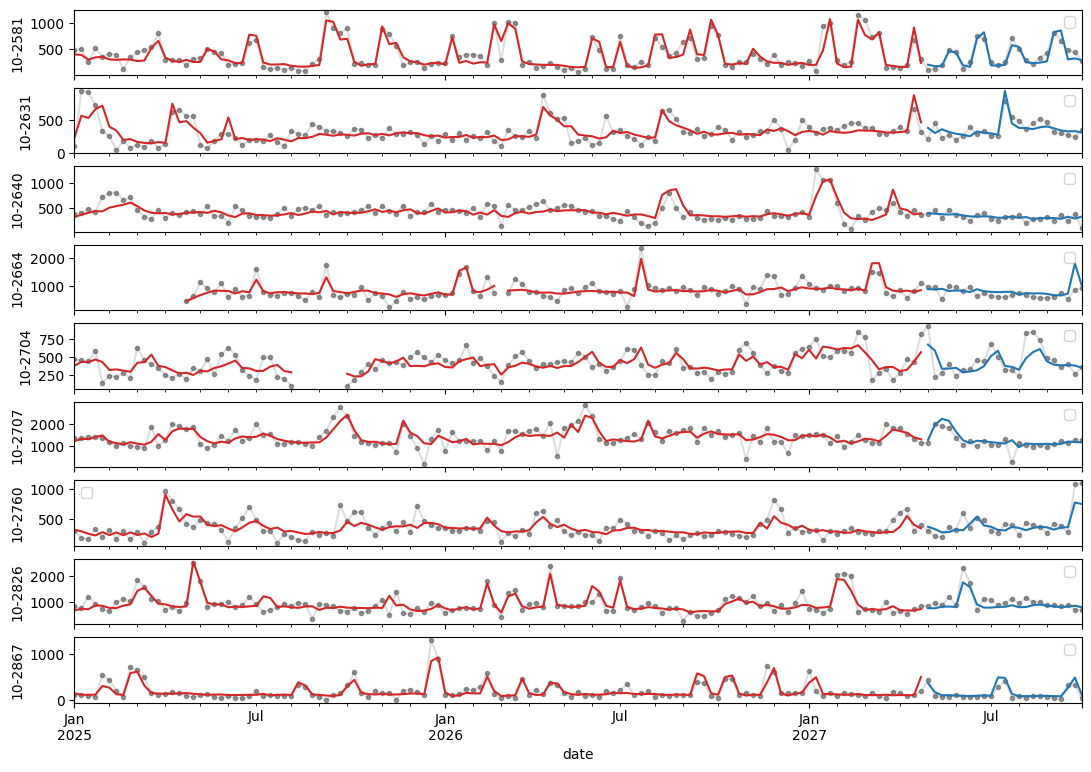

In [96]:
plot_params = dict(
    color='0.75',
    style='.-',
    markeredgecolor='0.25',
    markerfacecolor='0.25',
    legend=False,
)

center_meal= '10-1109'
families =y_unstack.columns[41:50] #[(center_meal)]
axs = y_unstack.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(13, 9), **plot_params, alpha=0.5,
)
_ = y_pred_valid_unstack.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred_unstack.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

## Model Evaluation and Conclusions

This project aimed to develop a hybrid model to predict the weekly demand for multiple products distributed across various logistics centers (77 centers and 51 products), in a highly seasonal environment with noise and realistic behavior. Based on the analysis of the time series behavior, I opted for a two-stage solution:

1. A deterministic model based on linear regression to capture the general trend.

2. An XGBoost Regressor model, trained on the residuals of the previous model, to capture non-linear relationships and complex effects, including prices, promotions, interactions, time-related variables, lags, and moving statistics.

During the process:
* I implemented time-based cross-validation using TimeSeriesSplit, which allowed performance evaluation while respecting the temporal order and avoiding data leakage.

* I used RandomizedSearchCV for hyperparameter tuning of the XGBoost model, helping to balance accuracy with computational efficiency.

***Model Performance:***

* The model achieved an average validation R² score of 0.81. With the use of increasing folds, I observed improved performance, reaching values between 0.83 and 0.85, demonstrating good generalization capacity, especially given the complexity of the problem.

* The model’s Mean Absolute Error (MAE) remained below the standard deviation of the target variable (~395), indicating a reasonable absolute error compared to the natural variability of demand.

* The Root Mean Squared Error (RMSE) averaged around 168, which—despite penalizing large errors—remained low compared to the full range of possible values. The model showed robustness to outliers.

***Key Design Decisions:***

* I used enable_categorical=True in XGBoost, which allowed me to handle categorical variables directly, without additional encoding. Additionally, XGBoost natively handles missing values.

* I incorporated variables derived from both business logic and statistical analysis, such as sensitivity_promo, discount_level, rolling_min/max, and seasonal components (day, month, season, year). Care was taken to avoid data leakage by using lag features and rolling statistics calculated only on past data.



---


***Business Insights:***

From a strategic perspective, the model has high potential to support operational planning in companies with complex logistics operations. It represents an efficient alternative in terms of computational resources and is interpretable and easily communicated to non-technical stakeholders.

The model effectively captured trends for the majority of the 3,597 center-product (center-meal) combinations. However, some challenges in the dataset were identified, such as:

* High variability and presence of outliers.
* Imbalance in the number of records per combination, with some having limited historical data.
* Multicollinearity between variables such as base_price and checkout_price.
* Low initial correlation between predictive features and the target variable (num_orders).

***Future Recommendations:***

Certain segments with lower performance were identified, possibly due to limited historical data or high variability. For these cases, I recommend future experiments using simplified models or seasonal adjustments:

* Perform clustering processes and segment modeling for groups with distinct behaviors.
* Explore unaccounted seasonality for difficult-to-predict cases.
* Incorporate external variables where available (e.g., events, weather, holidays).
* testing more advanced models or ensemble (stacking) methods and compare metrics.